# Gromacs engines
This notebook showcases the use of the python classes used to steer gromacs from python. It will only work if the gromacs executables are available (e.g. in your `$PATH` variable).

There are two main classes you will use together:
 - `aimmd.distributed.MDP`, a python class which parses a gromacs molecular dynamics parameter file (`.mdp`) and makes its content available via a dictionary-like interface
 - the `aimmd.distributed.GmxEngine` or the `aimmd.distributed.SlurmGmxEngine`, both share a common interface and are `aysnc/await` enabled python wrappers to run gromacs locally or via the SLURM workload manager, respectively

### Imports and some basic checks that everything is available

In [1]:
%%bash
# if using the module system to make gromacs and friends available:
# check that they are loaded!
#module list

In [2]:
%%bash
# unix only, check that gmx is available
which gmx

/Modules/Data/gromacs/install/2020.0/bin/gmx


In [3]:
%matplotlib inline

In [4]:
import os
import asyncio
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda

In [5]:
import aimmd
import aimmd.distributed as aimmdd

### Setup working directory and the number of gromacs simulations to run in parallel

In [6]:
n_engines = 4

#scratch_dir = "."
scratch_dir = "/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/"
#scratch_dir = "/home/think/scratch/aimmd_distributed/"
wdirs = [os.path.join(scratch_dir, f"engine_wdir{i}") for i in range(n_engines)]

for d in wdirs:
    if not os.path.isdir(d):
        os.mkdir(d)

## `aimmd.distributed.GmxEngine` (and `aimmd.distributed.SlurmGmxEngine`)
Both provide the functionality of the gromacs grompp and mdrun executables in one class, i.e. given molecular dynamics parameters and possibly an initial configuration they will setup and steer a MD run. Their interfaces differ only in the additional `sbatch_script` that the slurm engine requires at initialization time, they can otherwise be used interchangeably. Both engines need the gromacs executables to be available, specifically `gmx grompp` and `gmx mdrun`  (`gmx_mpi mdrun` for the `SlurmGmxEngine`). The `SlurmGmxEngine` naturally also must have access to the slurm executables, specifically `sbatch`, `sacct` and `scancel`. However all of these can be set either at initialization time via keyword arguments or globally as attributes to the uninitialized class.

Each engine has a `prepare()` method (which will call `grompp`) and multiple methods to then run the simulation, namely `run()`, `run_walltime()` and `run_nsteps()`. The additional `prepare_from_files()` method can be used to continue a previous MD run from given `deffnm` and `workdir` (assuming all files/parts are there), note that it will (currently) not call `grompp` again and therefore assumes that the portable run input file (`.tpr`) allows for the continuation (i.e. has no or a sufficiently large integration step limit).

In [7]:
# Let us create a list of identical engines to showcase the power of concurrent execution :)
engines = [aimmdd.GmxEngine(gro_file="gmx_infiles/conf.gro",  # required
                            top_file="gmx_infiles/topol.top",  # required
                            ndx_file="gmx_infiles/index.ndx",  # optional (can be omited or None), however naturally without an index file
                                                               # you can not reference custom groups in the .mdp-file or MDP object 
                            # limit each engine to 2 threads (the box is so small that otherwise the domain decomposition fails)
                            #mdrun_extra_args="-nt 2",  # use this if your version of GMX is compiled with thread-MPI support
                            mdrun_extra_args="-ntomp 2",  # use this for GMX without thread-MPI support
                            )
           for _ in range(n_engines)]

## `aimmd.distributed.MDP`
The `MDP` is a dictionary-like interface to a parsed gromacs molecular dynamics parameter file `.mdp` file to enable easy inspection and modification from python code. Most of the values are automatically cast to their respective types, e.g. `nsteps` will always be an `int` and `ref-t` will always be a list of `float`. The default for unknow parameters is a list of `str` to allow for the highest felxibility possible.

The class supports writing of its (possibly changed) content to a new `.mdp` file by using its `.write()` method and also knows if its content has been changed since parsing the original `.mdp` file. It even supports the (undocumented) keyformat CHARMM-GUI uses in which all `-` are replaced by `_`.

In [8]:
# one MDP object per engine, in principal we could use the same object but this way is more customizable,
# e.g. we could want to modify our setup have the engines run at a different temperatures
mdps = [aimmdd.MDP("gmx_infiles/md.mdp") for _ in range(n_engines)]

In [9]:
# lets have a look at what is inside
print("MDP has been changed since parsing: ", mdps[0].changed)
print("Parsed content:")
print("---------------")
for key, val in mdps[0].items():
    print(key, " : ", val)

MDP has been changed since parsing:  False
Parsed content:
---------------
title  :  ['test']
cpp  :  ['/lib/cpp']
include  :  ['-I../top']
define  :  []
integrator  :  ['md-vv']
dt  :  0.002
nsteps  :  -1
nstxout  :  10
nstvout  :  10
nstlog  :  10
nstenergy  :  10
nstxout-compressed  :  10
compressed-x-grps  :  ['Protein', 'SOL']
energygrps  :  ['Protein', 'SOL']
nstlist  :  10
ns-type  :  ['grid']
cutoff-scheme  :  ['Verlet']
rlist  :  1.1
coulombtype  :  ['PME']
rcoulomb  :  1.1
rvdw  :  1.1
tcoupl  :  ['Berendsen']
tc-grps  :  ['Protein', 'SOL']
tau-t  :  [0.1, 0.1]
ref-t  :  [300.0, 300.0]
Pcoupl  :  ['Berendsen']
tau-p  :  1.0
compressibility  :  [4.5e-05]
ref-p  :  [1.0]
gen-vel  :  ['no']
gen-temp  :  300.0
gen-seed  :  173529
constraints  :  ['all-bonds']
lincs-iter  :  6


In [10]:
# lets set the xtc output frequency to 0 in all MDPs, we will use the trr anyways
# we will also increase the trr output frequency by a bit and add the `continuation` parameter
nstout = 20
for mdp in mdps:
    mdp['nstvout'] = nstout
    mdp["nstxout"] = nstout
    mdp["nstlog"] = nstout
    mdp["nstenergy"] = nstout
    mdp["nstxout-compressed"] = 0
    mdp["continuation"] = "yes"  # dont apply constraints to the initial configuration

In [11]:
# have a look again
print("MDP has been changed since parsing: ", mdps[0].changed)
print("Parsed content:")
print("---------------")
for key, val in mdps[0].items():
    print(key, " : ", val)

MDP has been changed since parsing:  True
Parsed content:
---------------
title  :  ['test']
cpp  :  ['/lib/cpp']
include  :  ['-I../top']
define  :  []
integrator  :  ['md-vv']
dt  :  0.002
nsteps  :  -1
nstxout  :  20
nstvout  :  20
nstlog  :  20
nstenergy  :  20
nstxout-compressed  :  0
compressed-x-grps  :  ['Protein', 'SOL']
energygrps  :  ['Protein', 'SOL']
nstlist  :  10
ns-type  :  ['grid']
cutoff-scheme  :  ['Verlet']
rlist  :  1.1
coulombtype  :  ['PME']
rcoulomb  :  1.1
rvdw  :  1.1
tcoupl  :  ['Berendsen']
tc-grps  :  ['Protein', 'SOL']
tau-t  :  [0.1, 0.1]
ref-t  :  [300.0, 300.0]
Pcoupl  :  ['Berendsen']
tau-p  :  1.0
compressibility  :  [4.5e-05]
ref-p  :  [1.0]
gen-vel  :  ['no']
gen-temp  :  300.0
gen-seed  :  173529
constraints  :  ['all-bonds']
lincs-iter  :  6
continuation  :  ['yes']


### Now that we have set the molecular dynamcis parameters we can prepare a gromacs MD run.
The gromacs engines `prepare()` method will call grompp, as with grompp you can use a specific starting configuration (the grompp `-t` option) or start the structure file (`.gro`) the engine got at initialization.

### Lets prepare the first engine without a starting structure:

In [12]:
e0 = engines[0]  # get it out of the list so tab-help/completion works

In [13]:
# the prepare method is an async def function (a coroutine) and must be awaited
await e0.prepare(starting_configuration=None, workdir=wdirs[0], deffnm="test", run_config=mdps[0])

### Lets prepare all other engines at once with the same initial configuration
We can use asyncio.gather to run all coroutines concurrently, for prepare this does not make a big difference (since it is fast), but the same mechanism enables us to run all 4 gromacs engines in parallel later.

In [14]:
# create an aimmd.distributed.Trajectory of the initial configuration
init_conf = aimmdd.Trajectory(trajectory_file="gmx_infiles/conf.trr",
                              structure_file="gmx_infiles/conf.gro",
                             )

In [15]:
# and prepare the engines (the return value of prepare is None)
await asyncio.gather(*(e.prepare(starting_configuration=init_conf, workdir=wdir, deffnm="test", run_config=mdp)
                       for e, wdir, mdp in zip(engines[1:], wdirs[1:], mdps[1:])
                       )
                     )

[None, None, None]

### Now run the engines for a number of steps each.
We will first run the last engine in the list alone and then all 4 concurrently for the same number of steps to show off the power of the concurrent execution of the gromacs subprocesses.

In [16]:
import time  # import time to be able to show off ;)

In [17]:
nsteps = 100000

# run one engine and time it
start = time.time()
# the engine will return an aimmd.distributed.Trajectory with the produced trajectory (part)
traj = await engines[-1].run_steps(nsteps=nsteps, steps_per_part=True)
end = time.time()

print(f"Running one engine for {nsteps} integration steps took {round(end - start, 4)} seconds.")
print(f"The produced trajectory ({traj}) has a length of {len(traj)} frames.")
print(f"This length is the number of steps divided by the engines output frequency (={engines[-1].nstout}).")
print("Note, that we are off by plus one because the initial configuration is in the trajectory for gromacs.")
print("Note also that this is only true when explicitly passing nsteps to the `run` methods, unfortunately the real relation between frames")
print("and steps done is a bit more involved...See the docstring for `GmxEngine.steps_done` if you are brave and want to know more ;)")

Running one engine for 100000 integration steps took 74.248 seconds.
The produced trajectory (Trajectory(trajectory_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir3/test.part0001.trr, structure_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir3/test.tpr)) has a length of 5001 frames.
This length is the number of steps divided by the engines output frequency (=20).
Note, that we are off by plus one because the initial configuration is in the trajectory for gromacs.
Note also that this is only true when explicitly passing nsteps to the `run` methods, unfortunately the real relation between frames
and steps done is a bit more involved...See the docstring for `GmxEngine.steps_done` if you are brave and want to know more ;)


/home/tb/hejung/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/topology/tpr/utils.py:389: DeprecationWarning: TPR files index residues from 0. From MDAnalysis version 2.0, resids will start at 1 instead. If you wish to keep indexing resids from 0, please set `tpr_resid_from_one=False` as a keyword argument when you create a new Topology or Universe.
  warnings.warn("TPR files index residues from 0. "


In [18]:
all_trajs_engine3 = [traj]

In [19]:
# run all engines at once and time it
start = time.time()
# Now each engine will return an aimmd.distributed.Trajectory with the produced trajectory (part)
# i.e. trajs will be a list of trajectories (in the same order as the engines in the list)
trajs = await asyncio.gather(*(e.run_steps(nsteps=nsteps, steps_per_part=True) for e in engines))
end = time.time()

print(f"Running all engines for {nsteps} integration steps took {round(end - start, 4)} seconds.")
print(f"But now we have a list of {len(trajs)} trajectories with {nsteps} steps each...")
for t in trajs:
    print(t, f" with length: {len(t)}")

/home/tb/hejung/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/topology/tpr/utils.py:389: DeprecationWarning: TPR files index residues from 0. From MDAnalysis version 2.0, resids will start at 1 instead. If you wish to keep indexing resids from 0, please set `tpr_resid_from_one=False` as a keyword argument when you create a new Topology or Universe.
  warnings.warn("TPR files index residues from 0. "


Running all engines for 100000 integration steps took 77.9275 seconds.
But now we have a list of 4 trajectories with 100000 steps each...
Trajectory(trajectory_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir0/test.part0001.trr, structure_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir0/test.tpr)  with length: 5001
Trajectory(trajectory_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir1/test.part0001.trr, structure_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir1/test.tpr)  with length: 5001
Trajectory(trajectory_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir2/test.part0001.trr, structure_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir2/test.tpr)  with length: 5001
Trajectory(trajectory_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir3/test.part0002.trr, structure_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir3/tes

In [20]:
all_trajs_engine3 += [trajs[3]]

### Use `prepare_from_files` to initialize new engines and pick up where we left off with the 'old' ones.

In [21]:
# create the engines
new_engines = [aimmdd.GmxEngine(gro_file="gmx_infiles/conf.gro",
                                top_file="gmx_infiles/topol.top",
                                ndx_file="gmx_infiles/index.ndx",
                                #mdrun_extra_args="-nt 2",  # use this if your version of GMX is compiled with thread-MPI support
                                mdrun_extra_args="-ntomp 2",  # use this for GMX without thread-MPI support
                                )
               for _ in range(n_engines)]
e0 = new_engines[0]  # get one out for the autocomplete

In [22]:
# and initialize with prepare_from_files
await e0.prepare_from_files(workdir=wdirs[0], deffnm="test")

In [23]:
# and the others concurrent in one go
await asyncio.gather(*(e.prepare_from_files(workdir=wdir, deffnm="test") for e, wdir in zip(new_engines[1:], wdirs[1:])))

[None, None, None]

### Now we can do another round of MD in all engines in parallel
Note that the partnums indicate that we picked up exactly where we left of. We could additionally check using the trajectories `.last_step` and `.first_step` properties, compare and observe that the last step in the previous MD runs will be the first step in these here.

In [24]:
# run all engines at once and time it
start = time.time()
trajs = await asyncio.gather(*(e.run_steps(nsteps=nsteps, steps_per_part=True) for e in new_engines))
end = time.time()

print(f"Running all engines for {nsteps} integration steps took {end - start} seconds.")
print(f"But now we have a list of {len(trajs)} trajectories with {nsteps} steps each...")
for t in trajs:
    print(t, f" with length: {len(t)}")

/home/tb/hejung/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/topology/tpr/utils.py:389: DeprecationWarning: TPR files index residues from 0. From MDAnalysis version 2.0, resids will start at 1 instead. If you wish to keep indexing resids from 0, please set `tpr_resid_from_one=False` as a keyword argument when you create a new Topology or Universe.
  warnings.warn("TPR files index residues from 0. "


Running all engines for 100000 integration steps took 77.3013505935669 seconds.
But now we have a list of 4 trajectories with 100000 steps each...
Trajectory(trajectory_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir0/test.part0002.trr, structure_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir0/test.tpr)  with length: 5001
Trajectory(trajectory_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir1/test.part0002.trr, structure_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir1/test.tpr)  with length: 5001
Trajectory(trajectory_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir2/test.part0002.trr, structure_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir2/test.tpr)  with length: 5001
Trajectory(trajectory_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir3/test.part0003.trr, structure_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_

In [25]:
all_trajs_engine3 += [trajs[3]]

### Run for specified walltime

In [26]:
walltime = 0.01 # 0.01 h = 36 s

# run all engines at once and time it
start = time.time()
trajs = await asyncio.gather(*(e.run_walltime(walltime) for e in new_engines))
end = time.time()

print(f"Running all engines for {walltime} h (={walltime*60*60} s) took {round(end - start, 4)} seconds.")

/home/tb/hejung/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/topology/tpr/utils.py:389: DeprecationWarning: TPR files index residues from 0. From MDAnalysis version 2.0, resids will start at 1 instead. If you wish to keep indexing resids from 0, please set `tpr_resid_from_one=False` as a keyword argument when you create a new Topology or Universe.
  warnings.warn("TPR files index residues from 0. "


Running all engines for 0.01 h (=36.0 s) took 38.7215 seconds.


In [27]:
all_trajs_engine3 += [trajs[3]]

### Run for specified walltime or number of steps (depending on what is reached first)
We can also use the generic `run()` method which takes one or both of the `walltime` and `nsteps` arguments, it will finish as soon as one of the conditions is fullfilled. As the `run_steps()` method it also accepts the `steps_per_part` argument making it particularly useful to run in chunks (of length walltime) but for a fixed total number of steps.

Note that we can either check if `engine.steps_done < n_steps_desired` (as we do below) or call the `engine.run(nsteps=n_steps_desired)` method until it returns `None` instead of a trajectory object, which indicates that the total number of steps done in that engine is exactly the requested number of total steps.

In [28]:
print([e.steps_done for e in new_engines])
print([e.steps_done < (max([e.steps_done for e in new_engines]) + 20000) for e in new_engines])

[247840, 248320, 248160, 348240]
[True, True, True, True]


In [29]:
walltime = 0.01 # 0.01 h = 36 s
nsteps = max([e.steps_done for e in new_engines]) + 20000

all_trajs = []
all_times = []
while any([e.steps_done < nsteps for e in new_engines]):
    # run all engines at once and time it
    start = time.time()
    trajs = await asyncio.gather(*(e.run(walltime=walltime, nsteps=nsteps, steps_per_part=False) for e in new_engines))
    end = time.time()
    all_trajs.append(trajs)
    all_times.append(end-start)

print(f"Ran for a total of {len(all_times)} loops. It took us {round(sum(all_times), 4)} seconds.")

/home/tb/hejung/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/topology/tpr/utils.py:389: DeprecationWarning: TPR files index residues from 0. From MDAnalysis version 2.0, resids will start at 1 instead. If you wish to keep indexing resids from 0, please set `tpr_resid_from_one=False` as a keyword argument when you create a new Topology or Universe.
  warnings.warn("TPR files index residues from 0. "
/home/tb/hejung/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/topology/tpr/utils.py:389: DeprecationWarning: TPR files index residues from 0. From MDAnalysis version 2.0, resids will start at 1 instead. If you wish to keep indexing resids from 0, please set `tpr_resid_from_one=False` as a keyword argument when you create a new Topology or Universe.
  warnings.warn("TPR files index residues from 0. "
/home/tb/hejung/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/topology/tpr/utils.py:389: DeprecationWarning: TPR fil

Ran for a total of 3 loops. It took us 92.8987 seconds.


In [30]:
# the last engine will probably already have produced a `None` instead of a trajectory in the last iteration
# (since it is some steps ahead of the others because we ran it alone at the beginning of the notebook)
all_trajs[-1]

[Trajectory(trajectory_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir0/test.part0006.trr, structure_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir0/test.tpr),
 Trajectory(trajectory_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir1/test.part0006.trr, structure_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir1/test.tpr),
 Trajectory(trajectory_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir2/test.part0006.trr, structure_file=/home/tb/hejung/DATA/aimmd_scratch/aimmd_distributed/engine_wdir2/test.tpr),
 None]

In [31]:
for trajs in all_trajs:
    if trajs[3] is not None:
        all_trajs_engine3 += [trajs[3]]

## Test concatenation

In [32]:
from state_funcs_mda import C7_eq, alpha_R

In [33]:
C7_eq_wrapped = aimmdd.PyTrajectoryFunctionWrapper(C7_eq)
# the optional call_kwargs argument can be used to specify additional keyword arguments
# [we pass skip=1 which does not do anything because it is the default value only to show that call_kwargs exists]
alpha_R_wrapped = aimmdd.PyTrajectoryFunctionWrapper(alpha_R, call_kwargs={"skip": 1})

In [34]:
C7_vals = []
alpha_vals = []
for i, t in enumerate(all_trajs_engine3):
    print(f"Trajectory with idx {i} has first step {t.first_step}, last step {t.last_step} and length {len(t)} frames.")
    print(f"First timestep {t.first_time}; last timestep {t.last_time}.")
    C7, alpha = await asyncio.gather(*(C7_eq_wrapped(t), alpha_R_wrapped(t)))
    C7_vals += [C7]
    alpha_vals += [alpha]

Trajectory with idx 0 has first step 0, last step 100000 and length 5001 frames.
First timestep 0.0; last timestep 200.0.
Trajectory with idx 1 has first step 100000, last step 200000 and length 5001 frames.
First timestep 200.0; last timestep 400.0.
Trajectory with idx 2 has first step 200000, last step 300000 and length 5001 frames.
First timestep 400.0; last timestep 600.0.
Trajectory with idx 3 has first step 300000, last step 348240 and length 2413 frames.
First timestep 600.0; last timestep 696.47998046875.
Trajectory with idx 4 has first step 348240, last step 368240 and length 1001 frames.
First timestep 696.47998046875; last timestep 736.47998046875.


In [35]:
from aimmd.distributed.trajectory import TrajectoryConcatenator

In [36]:
concatenator = TrajectoryConcatenator()

In [37]:
slices_for_bw = [(len(t), None, -1) for t in all_trajs_engine3[::-1]]

In [38]:
slices_for_bw

[(1001, None, -1),
 (2413, None, -1),
 (5001, None, -1),
 (5001, None, -1),
 (5001, None, -1)]

In [39]:
traj_inverted = concatenator.concatenate(trajs=all_trajs_engine3[::-1],
                                         slices=slices_for_bw,
                                         tra_out="inverted.trr")

In [40]:
len(traj_inverted)

/home/tb/hejung/.conda/envs/aimmd_nature_publish/lib/python3.8/site-packages/MDAnalysis/coordinates/XDR.py:216: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


18413

In [41]:
traj_inverted.first_step

1000

In [42]:
traj_inverted.last_step

0

In [43]:
print(traj_inverted.first_time)
print(traj_inverted.last_time)
print(traj_inverted.dt)

736.47998046875
0.0
-0.03997802734375


In [44]:
slices = [(0, None, 1) for _ in range(len(all_trajs_engine3))]

In [45]:
concatenated = concatenator.concatenate(trajs=all_trajs_engine3,
                                        slices=slices,
                                        tra_out="concatenated.trr")

In [46]:
len(concatenated)

18413

In [47]:
concatenated.first_step

0

In [48]:
concatenated.last_step

1000

In [49]:
print(concatenated.first_time)
print(concatenated.last_time)
print(concatenated.dt)

0.0
736.47998046875
0.03999999910593033


In [50]:
ui = mda.Universe(traj_inverted.structure_file, traj_inverted.trajectory_file)
ts = ui.trajectory[2]
print(ts.data)

{'time': 736.4000244140625, 'step': 998, 'lambda': 0.0, 'dt': -0.03997802734375}


In [51]:
uc = mda.Universe(concatenated.structure_file, concatenated.trajectory_file)
ts = uc.trajectory[-3]
print(ts.data)

{'time': 736.4000244140625, 'step': 998, 'lambda': 0.0, 'dt': 0.03999999910593033}


In [52]:
C7_for_concat, alpha_for_concat = await asyncio.gather(*(C7_eq_wrapped(concatenated), alpha_R_wrapped(concatenated)))

In [53]:
C7_for_invert, alpha_for_invert = await asyncio.gather(*(C7_eq_wrapped(traj_inverted), alpha_R_wrapped(traj_inverted)))

In [54]:
sum(len(t) for t in all_trajs_engine3)

18417

<ipython-input-55-e118bd9eb030>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axs.plot(np.concatenate(C7_vals, dtype=np.int) - np.asarray(C7_for_concat, dtype=np.int), label="traj parts")


ValueError: operands could not be broadcast together with shapes (18417,) (18413,) 

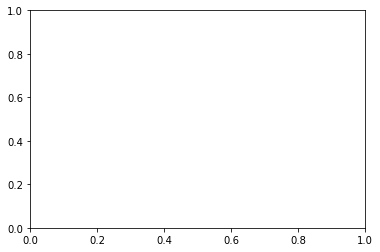

In [55]:
fig, axs = plt.subplots()

#axs.plot(C7_for_concat, label="concat")
#axs.plot(C7_for_invert[::-1], label="invert")
axs.plot(np.concatenate(C7_vals, dtype=np.int) - np.asarray(C7_for_concat, dtype=np.int), label="traj parts")

plt.legend()

In [58]:
u0 = mda.Universe(all_trajs_engine3[0].structure_file, all_trajs_engine3[0].trajectory_file)
ts = u0.trajectory[-1]
print(ts.data["step"])
print(ts.data)


100000
{'time': 200.0, 'step': 100000, 'lambda': 0.0, 'dt': 0.03999999910593033}


In [57]:
u1 = mda.Universe(all_trajs_engine3[1].structure_file, all_trajs_engine3[1].trajectory_file)
ts = u1.trajectory[0]
print(ts.data["step"])
print(ts.data)

100000
{'time': 200.0, 'step': 100000, 'lambda': 0.0, 'dt': 0.0399932861328125}
